Adaptive Gaussian Process Change Point Detection is a more advanced technique for detecting change points in time series data using Gaussian Process models. In this method, a Gaussian Process (GP) model is used to model the underlying data distribution, and change points are detected by monitoring the uncertainty or variance in the GP predictions. When there is a significant change in the data, it is likely to be associated with an increase in prediction uncertainty.




1.   Cumulative Sum (CUSUM): This algorithm works by calculating the cumulative
sum of the deviations from the expected mean or trend. When the cumulative sum exceeds a predefined threshold, a change is detected.

2.   Exponentially Weighted Moving Average (EWMA): This algorithm calculates the moving average of the data, where more recent data points are given more weight. When the current value deviates from the expected value beyond a certain threshold, a change is detected.

3.   Bayesian Change Point Analysis: This algorithm uses Bayesian inference to estimate the probability of a change point in the time series. It works by modeling the time series as a sequence of segments with different parameters, and then calculating the posterior probability of a change point.

4.   Singular Spectrum Analysis (SSA): This algorithm decomposes the time series into several components, including trend, seasonal, and noise components. Changes in the trend or seasonality can be detected by analyzing the changes in these components.

5.   Wavelet Transform: This algorithm decomposes the time series into different frequency components using wavelet transform. Changes in the time series can be detected by analyzing the changes in the frequency components.



# 1- Adaptive Change point detection

In [ ]:
pip install GPy numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420174 sha256=89e1648442e156dc3d2140594b0fcdead4021da0a14ef5d28f56f86ab95d5891
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102544 sha256=5929ad5e84902b032be9834a9401c251c8dbb0a3fdd002cdaf1b1d56a80bd21e
  Stored in directory: /root/.cache/pip/wheels/d2/ef/9c/da9ceef7d0ff5287c24365844fc394852c2b79ac3fcf33bf8b
Successfully built GPy paramz


In [ ]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

In [ ]:
# Generate synthetic time series data
np.random.seed(0)
n_points = 100
x = np.linspace(0, 10, n_points)
y = np.concatenate([np.random.normal(0, 0.5, 50), np.random.normal(3, 0.5, 50)])


In [ ]:
def fit_gp(x, y):
    kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
    model = GPy.models.GPRegression(x.reshape(-1, 1), y.reshape(-1, 1), kernel)
    model.optimize()  # Optimize the GP model parameters
    return model


In [ ]:
def detect_change_points(x, y, significance_threshold=1.0):
    model = fit_gp(x, y)

    # Calculate the standard deviation (uncertainty) of GP predictions
    _, var = model.predict(x.reshape(-1, 1), full_cov=False)

    # Find change points based on the significance threshold
    change_points = []
    for i in range(1, len(x)):
        if var[i] > significance_threshold * np.mean(var[:i]):
            change_points.append(i)

    return change_points

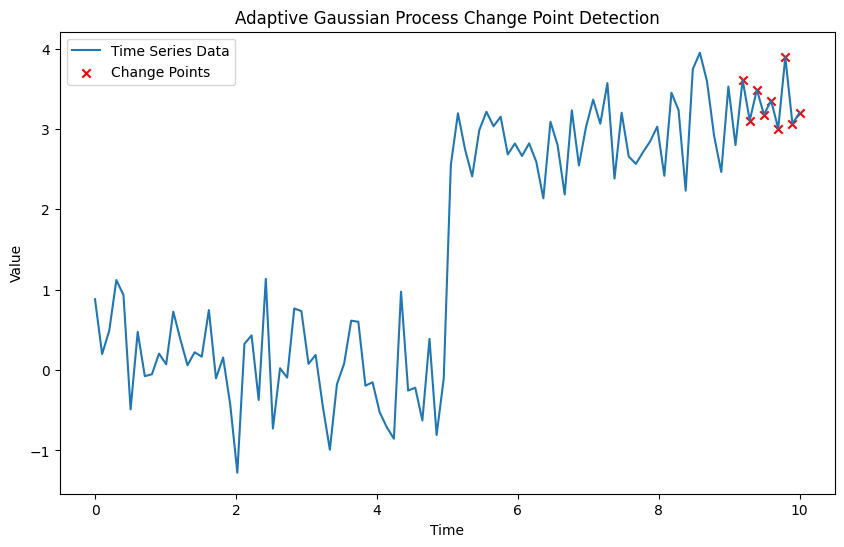

Detected Change Points: [91, 92, 93, 94, 95, 96, 97, 98, 99]


In [ ]:
change_points = detect_change_points(x, y, significance_threshold=1.0)

# Plot the time series data and detected change points
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Time Series Data')
plt.scatter(x[change_points], y[change_points], color='red', marker='x', label='Change Points')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Adaptive Gaussian Process Change Point Detection')
plt.show()

print("Detected Change Points:", change_points)


# 2- Abrupt change detection

In [ ]:
np.random.seed(123)
# Make some data with a changepoint at t = 10
data = np.concatenate([np.random.normal(1.5, 0.1, 10),
                          np.random.normal(0, 0.1, 10)])

In [ ]:
pip install ruptures


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

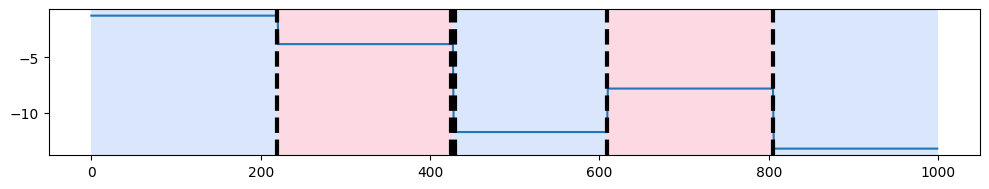

In [ ]:
import numpy as np
import ruptures as rpt

# Create a signal with 'changepoints'
n, dim = 1000, 1  # number of samples, dimension
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n, dim, n_bkps)

# Change point detection with the PELT algorithm
model = "l2"  # "l2" cost function (least squares), you can change it according to your needs
algo = rpt.Pelt(model=model, min_size=1, jump=5).fit(signal)
result = algo.predict(pen=10)

# Display
rpt.display(signal, bkps, result)


In [ ]:
import pandas as pd

def detect_abrupt_changes(signal, percent_change, max_time_interval):
    """
    Detect abrupt changes in a time series signal based on the specified parameters.

    Parameters:
        signal (pandas.Series): One-dimensional time series signal.
        percent_change (float): The minimum percentage change in the signal range that is considered an abrupt change.
        max_time_interval (int): The maximum time interval in samples between two data points to be considered part of the same change.

    Returns:
        pandas.Series: A boolean mask indicating the positions of the abrupt changes in the input signal.
    """
    # Calculate the absolute change in the signal.
    abs_change = abs(signal.diff())

    # Calculate the threshold for the minimum change required to be considered an abrupt change.
    change_threshold = (signal.max() - signal.min()) * percent_change

    # Initialize a mask of False values to indicate no abrupt changes have been detected yet.
    abrupt_changes = pd.Series(False, index=signal.index)

    # Loop over each data point in the signal.
    for i in range(1, len(signal)):
        # If the absolute change is greater than the threshold, mark this data point as the start of an abrupt change.
        if abs_change[i] >= change_threshold:
            abrupt_changes[i] = True

            # Keep track of the end of the current change.
            end_of_change = i

            # Continue checking subsequent data points to see if they are still part of the same change.
            for j in range(i+1, min(i+max_time_interval, len(signal))):
                if abs_change[j] >= change_threshold:
                    # If the change is still above the threshold, mark this data point as part of the same change.
                    abrupt_changes[j] = True

                    # Update the end of the current change.
                    end_of_change = j
                else:
                    # If the change has fallen below the threshold, stop checking subsequent data points.
                    break

            # Skip checking data points that are already part of the current change.
            i = end_of_change

    return abrupt_changes

In [ ]:

import pandas as pd
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Generate a random time series with 1000 data points
signal = pd.Series(np.random.normal(0, 1, 1000), index=pd.date_range('2022-01-01', periods=1000, freq='D'))

# Add some abrupt changes to the time series
signal.loc['2022-02-05':'2022-02-15'] -= 5
signal.loc['2022-03-10':'2022-03-20'] += 3.5
signal.loc['2022-04-05':'2022-04-08'] -= 4


In [ ]:

abrupt_changes = detect_abrupt_changes(signal, 0.1, 5)
print(abrupt_changes)

2022-01-01    False
2022-01-02    False
2022-01-03    False
2022-01-04    False
2022-01-05     True
              ...  
2024-09-22    False
2024-09-23     True
2024-09-24    False
2024-09-25     True
2024-09-26    False
Freq: D, Length: 1000, dtype: bool


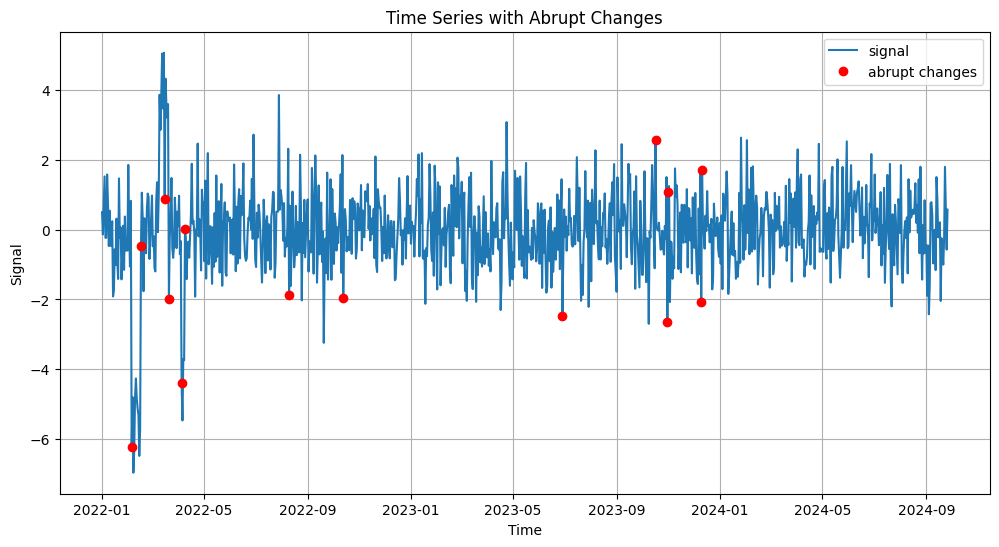

In [ ]:
import matplotlib.pyplot as plt

# Plot the time series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(signal, label='signal')

# Plot the abrupt changes
abrupt_changes = detect_abrupt_changes(signal, 0.3, 10)
abrupt_changes = abrupt_changes.astype(int)
ax.plot(signal[abrupt_changes==1], 'ro', label='abrupt changes')

# Add labels, grid, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Time Series with Abrupt Changes')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def generate_signal(num_points):
    """
    Generate a stochastic signal with multiple change points in mean and standard deviation.
    """
    s = np.zeros(num_points)
    s = np.concatenate([np.random.normal(loc=0, scale=1, size=num_points // 6),
                              np.random.normal(loc=1.0, scale=1, size=num_points // 6),
                              np.random.normal(loc=1.0, scale=2, size=num_points // 6),
                              np.random.normal(loc=5, scale=1, size=num_points // 6),
                              np.random.normal(loc=5, scale=2, size=num_points // 6),
                              np.random.normal(loc=-2, scale=1, size=num_points // 6)])
    # Set the random seed for reproducibility

    # Generate a random time series with 1000 data points
    signal = pd.Series(s, index=pd.date_range('2022-01-01', periods=num_points, freq='D'))
    return signal

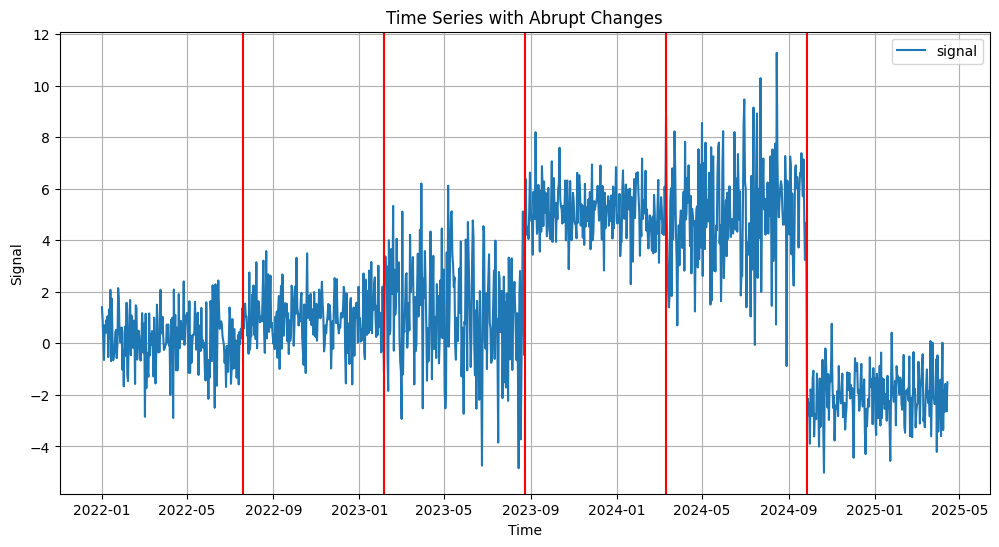

In [ ]:

import matplotlib.pyplot as plt

# Create a random stochastic time series with different regions
n = 1200
signal = generate_signal(1200)

# mark changes
result = [n//6,2*n//6,3*n//6,4*n//6,5*n//6]

# Plot the time series with change point locations
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(signal, label='signal')
for i in signal.index[result]:
    ax.axvline(i, color='r')

# Add labels, grid, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Time Series with Abrupt Changes')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

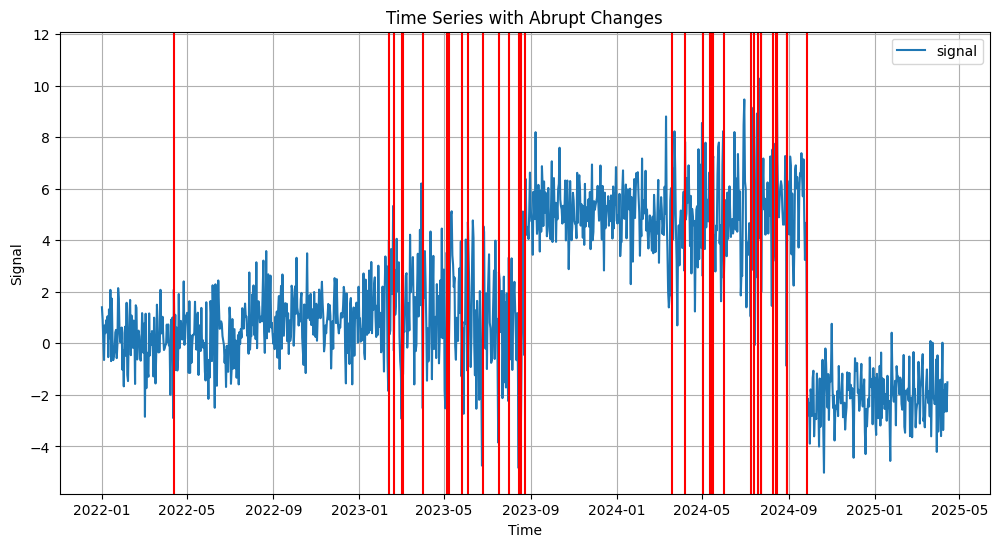

In [ ]:

# Detect abrupt changes
abrupt_changes = detect_abrupt_changes(signal, 0.3, 10)
abrupt_changes = abrupt_changes.astype(int)

# Plot the time series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(signal, label='signal')

# Plot the abrupt changes
for i in signal.index[abrupt_changes == 1]:
    ax.axvline(i, color='r')

# Add labels, grid, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Time Series with Abrupt Changes')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np

def detect_abrupt_changes(signal, percent_change, max_interval):
    """
    Detects abrupt changes in a time series signal.

    Args:
        signal (pandas.Series): One-dimensional time series signal.
        percent_change (float): Minimum percent change for detecting an abrupt change.
        max_interval (int): Maximum time interval within which the change should happen (in number of samples).

    Returns:
        list: A list containing the following:
            - pandas.Series: A boolean series indicating whether an abrupt change has occurred.
            - pandas.Series: A rolling mean series calculated over a window of size max_interval.
    """
    # Calculate the threshold for the minimum change required to be considered an abrupt change.
    change_threshold = (signal.max() - signal.min()) * percent_change # MODIFCATION

    # Calculate the minimum and maximum in the moving window
    rolling_mean = signal.rolling(window=max_interval, center=True).mean()

    # Calculate the difference between the local minimum and maximum
    diff = abs(signal - rolling_mean)

    # Calculate the percent change from the local minimum to the local maximum
    #percent_diff = diff / rolling_min * 100 # MODIFCATION

    # Detect abrupt changes
    abrupt_changes = diff > change_threshold
    return [abrupt_changes, rolling_mean]

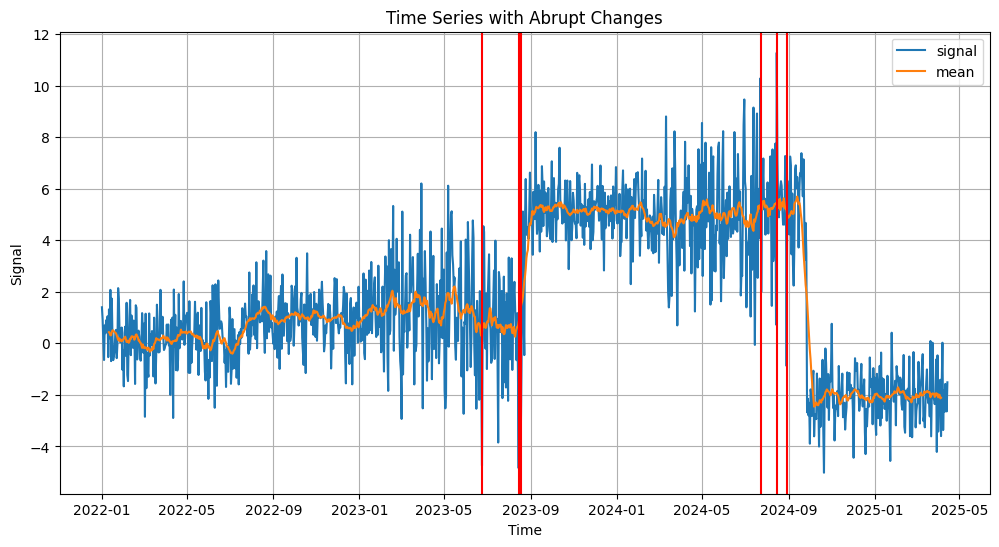

In [ ]:

# Detect abrupt changes
abrupt_changes, rolling_mean = detect_abrupt_changes(signal, 0.3, 20)
abrupt_changes = abrupt_changes.astype(int)

# Plot the time series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(signal, label='signal')
ax.plot(rolling_mean, label='mean')

# Plot the abrupt changes
for i in signal.index[abrupt_changes == 1]:
    ax.axvline(i, color='r')

# Add labels, grid, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Time Series with Abrupt Changes')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

In [ ]:

import pandas as pd
import numpy as np

def detect_abrupt_changes_rolling(signal, percent_change, max_interval):
    """
    Detects abrupt changes in a time series signal.

    Args:
        signal (pandas.Series): One-dimensional time series signal.
        percent_change (float): Minimum percent change for detecting an abrupt change.
        max_interval (int): Maximum time interval within which the change should happen (in number of samples).

    Returns:
        list: A list containing the following:
            - pandas.Series: A boolean series indicating whether an abrupt change has occurred.
            - pandas.Series: A rolling mean series calculated over a window of size max_interval.
            - pandas.Series: A rolling standard deviation series calculated over a window of size 4*max_interval.
    """

    # Calculate the minimum and maximum in the moving window
    rolling_mean = signal.rolling(window=max_interval, center=True).mean()
    rolling_std = signal.rolling(window=4*max_interval, center=True).std() # MODIFCATION

    # Calculate the threshold for the minimum change required to be considered an abrupt change.
    change_threshold = 2*rolling_std * percent_change


    # Calculate the difference between the local minimum and maximum
    diff = abs(signal - rolling_mean)

    # Calculate the percent change from the local minimum to the local maximum
    #percent_diff = diff / rolling_min * 100 # MODIFCATION

    # Detect abrupt changes
    abrupt_changes = diff > change_threshold
    return [abrupt_changes, rolling_mean, rolling_std]

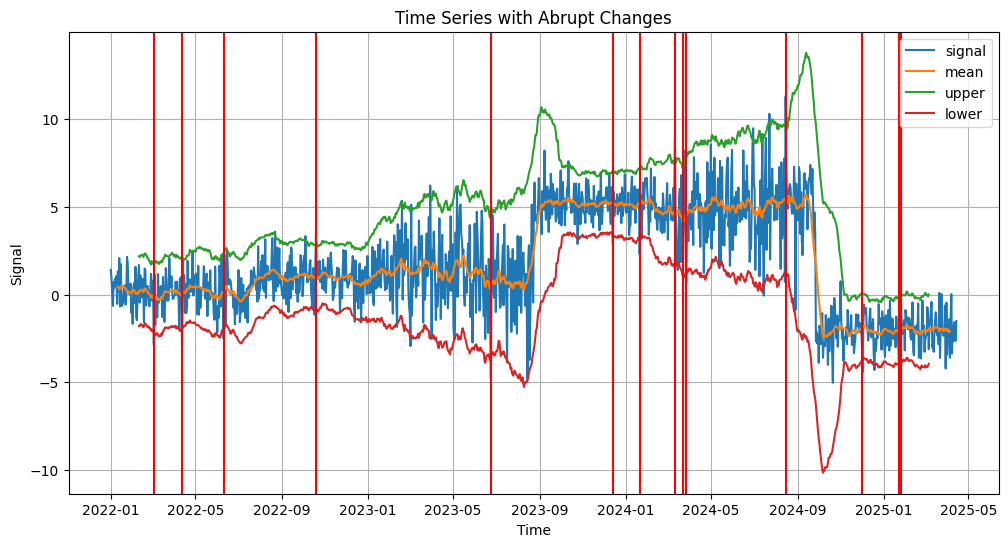

In [ ]:
# Detect abrupt changes
abrupt_changes, rolling_mean, rolling_std = detect_abrupt_changes_rolling(signal, 1.2, 20)
abrupt_changes = abrupt_changes.astype(int)

# Plot the time series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(signal, label='signal')
ax.plot(rolling_mean, label='mean')
ax.plot(rolling_mean+2*rolling_std, label='upper')
ax.plot(rolling_mean-2*rolling_std, label='lower')

# Plot the abrupt changes
for i in signal.index[abrupt_changes == 1]:
    ax.axvline(i, color='r')

# Add labels, grid, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Time Series with Abrupt Changes')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import ruptures as rpt

def detect_changes(time_series):
    # Convert time series to a numpy array
    signal = time_series.values

    # Set up the ruptures detector
    algo = rpt.Dynp(model="l2", min_size=1, jump=1).fit(signal)
    # "model" specifies the type of cost function to use
    # "min_size" specifies the minimum length of each segment
    # "jump" specifies the minimum distance between change points

    # Detect the change points
    #result = algo.predict(n_bkps=1) # MODIFICATION

    # use the MPE criterion to automatically select the number of change points
    #result = algo.predict(pen=2) # MODIFICATION, didn't work
    #result = algo.fit_predict(signal, pen=2) # MODIFICATION 2, didn't work either

    # Convert the result to a list of change point locations
    change_points = np.where(result == 1)[0].tolist()

    # Add the start and end points to the list
    change_points = [0] + change_points + [len(signal) - 1]

    # Return the list of change point locations
    return change_points

In [ ]:

import numpy as np
import pandas as pd
import ruptures as rpt

def detect_changes(time_series):
    # Convert time series to a numpy array
    signal = time_series.values

    # Perform change point detection using the Pelt algorithm
    algo = rpt.Pelt(model="rbf", min_size=1, jump=10).fit(signal)
    result = algo.predict(pen=2)

    # remove location if equal to len(signal)
    change_points = [i for i in result if i < len(signal)]

    # Return the list of change point locations
    return change_points


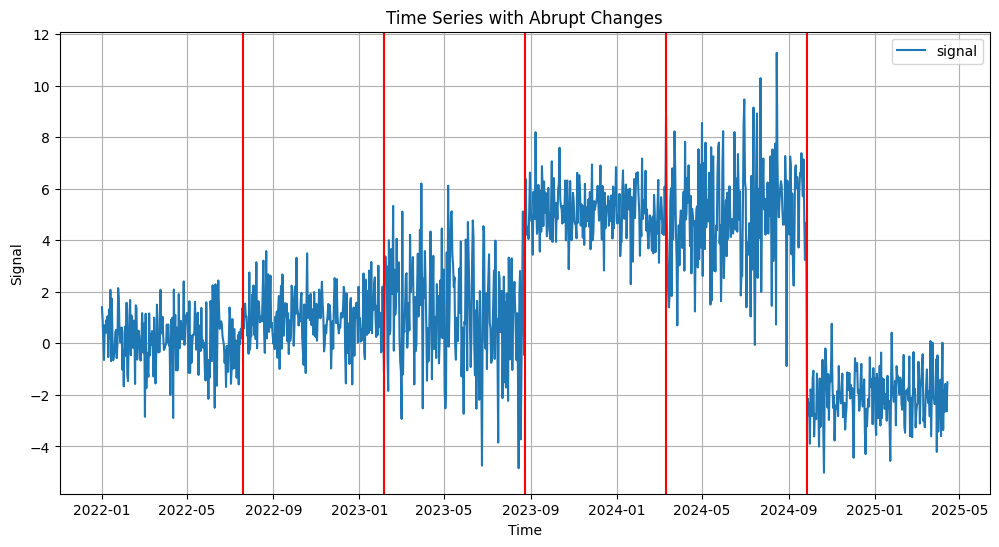

In [ ]:

# Detect abrupt changes
changes = detect_changes(signal)
#abrupt_changes = abrupt_changes.astype(int)

# Plot the time series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(signal, label='signal')

# Plot the abrupt changes
for i in changes:
    ax.axvline(signal.index[i], color='r')

# Add labels, grid, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Time Series with Abrupt Changes')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()